<a href="https://colab.research.google.com/github/Sai-Srikar-Boddupalli/OmniscientVideo/blob/main/Gett_Failed_Orders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Operational Analysis of Failed Orders (Gett)

**Author:** Sai Srikar Boddupalli
**Role:** Data Engineer
**Date:** January 2026

## Executive Summary
Gett (a corporate ride-hailing app) faces a significant challenge with failed orders—rides that represent lost revenue and frustrated customers.

**The Goal:**
This project analyzes the root causes of these failures. By examining cancellation timestamps, hourly trends, and geospatial clusters, we aim to provide actionable insights to the Operations Team to reduce churn.

**Key Technical Achievements:**
* **Feature Engineering:** Decoded cryptic status keys into human-readable failure reasons.
* **Behavioral Analysis:** Quantified customer "patience thresholds" to identify algorithm inefficiencies.
* **Geospatial Optimization:** Implemented H3 Hexagon clustering to pinpoint the top 20% of locations causing 80% of failures (Pareto Principle).

## 1. Environment Setup & Data Loading
First, we import the necessary libraries. We are using **Pandas** for data manipulation and **Folium/H3** for the geospatial analysis. We then load the two primary datasets: `orders` (ride details) and `offers` (driver interactions).

In [3]:
!pip install h3 folium


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.2 MB/s eta 0:00:00


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import h3
import folium
import warnings

# Suppress minor warnings for a cleaner output
warnings.filterwarnings('ignore')

# Load the datasets
df_orders = pd.read_csv('orders.csv')
df_offers = pd.read_csv('offers.csv')

# Display the first few rows to verify the schema
print("--- ORDERS SAMPLE ---")
display(df_orders.head(3))

--- ORDERS SAMPLE ---


,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0


## 2. Data Cleaning & Feature Engineering
The raw data uses numerical codes for statuses (e.g., `4`, `9`). To make this analysis interpretable for stakeholders, we must translate these into descriptive categories.

We also noticed a critical distinction in the "Client Cancelled" category:
1.  **Client Cancel (Searching):** The user cancelled *before* a driver was found.
2.  **Client Cancel (Driver Assigned):** The user cancelled *after* a driver was found.

Distinguishing between these two is vital for understanding if the issue is **matching speed** (searching) or **driver behavior** (assigned).

In [5]:
# Function to decode status keys into readable reasons
def get_failure_reason(row):
    if row['order_status_key'] == 9:
        return 'System Reject (No Driver)'
    elif row['order_status_key'] == 4:
        if row['is_driver_assigned_key'] == 1:
            return 'Client Cancel (Driver Assigned)'
        else:
            return 'Client Cancel (Searching)'
    else:
        return 'Other'

# Apply the transformation
df_orders['failure_reason'] = df_orders.apply(get_failure_reason, axis=1)

# Verify the new distribution
print(df_orders['failure_reason'].value_counts())

failure_reason
Client Cancel (Searching)          4496
System Reject (No Driver)          3409
Client Cancel (Driver Assigned)    2811
Name: count, dtype: int64


## 3. Analysis: Why are orders failing?
We begin by visualizing the distribution of failure reasons. This helps us identify the primary bottleneck in the order lifecycle.

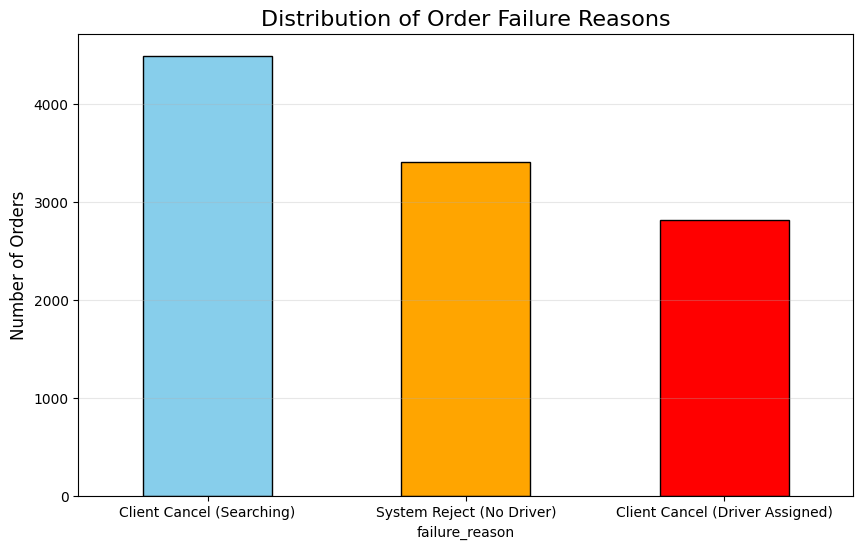

In [6]:
# Visualize the breakdown of failure reasons
plt.figure(figsize=(10, 6))
df_orders['failure_reason'].value_counts().plot(kind='bar', color=['skyblue', 'orange', 'red'], edgecolor='black')

plt.title('Distribution of Order Failure Reasons', fontsize=16)
plt.ylabel('Number of Orders', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

**Insight:**
The chart reveals that **"Client Cancel (Searching)"** is the most frequent failure type. This suggests that customers are abandoning the app because the wait time to *find* a driver is too long, rather than rejecting the driver they are assigned.

## 4. Behavioral Analysis: The "Patience Threshold"
How long are customers willing to wait?

We analyze the `cancellations_time_in_seconds` to determine the average time-to-cancellation. We filter out outliers (top 5% extreme wait times) to ensure our average represents the typical user.

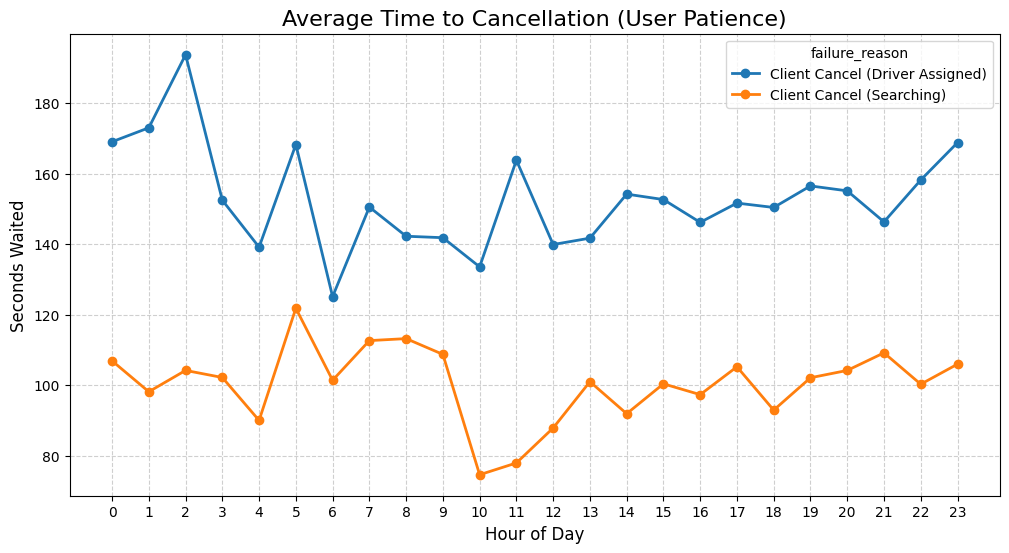

In [7]:
# 1. Filter out system rejects (instant failures)
df_clean = df_orders[df_orders['failure_reason'] != 'System Reject (No Driver)']

# 2. Convert timestamp to datetime and extract Hour
df_clean['order_datetime'] = pd.to_datetime(df_clean['order_datetime'])
df_clean['order_hour'] = df_clean['order_datetime'].dt.hour

# 3. Remove Outliers (95th percentile cut-off)
cutoff_value = df_clean['cancellations_time_in_seconds'].quantile(0.95)
df_final = df_clean[df_clean['cancellations_time_in_seconds'] < cutoff_value]

# 4. Aggregate average wait time by hour and reason
time_stats = df_final.groupby(['order_hour', 'failure_reason'])['cancellations_time_in_seconds'].mean().unstack()

# Plot the trends
time_stats.plot(kind='line', figsize=(12, 6), linewidth=2, marker='o')
plt.title('Average Time to Cancellation (User Patience)', fontsize=16)
plt.ylabel('Seconds Waited', fontsize=12)
plt.xlabel('Hour of Day', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(0, 24))
plt.show()

**Insight:**
There is a clear psychological difference in user behavior:
* **Searching Phase (Orange Line):** Users give up quickly, typically after **~100 seconds**.
* **Driver Assigned Phase (Blue Line):** Once matched, users are willing to wait nearly **twice as long (~200+ seconds)** before cancelling.

**Recommendation:** To reduce churn, the app must match drivers within the first 90 seconds. If a match isn't found, offering an incentive or a "We're still looking" notification could extend user patience.

## 5. Geospatial Optimization: The 80/20 Rule
Finally, we map the failures to see if they are distributed evenly or clustered in specific "dead zones."

We use the **H3 Hexagon Indexing System** (Resolution 8) to group failures by location. We then apply the Pareto Principle to identify the top hexes responsible for 80% of all failed orders.

In [8]:
# 1. Clean data for mapping
df_map = df_orders.dropna(subset=['origin_latitude', 'origin_longitude']).copy()

# 2. Convert Lat/Lon to H3 Hexagon ID (Resolution 8)
# Note: Using h3-py version 4 syntax
def get_hex_id(row):
    return h3.latlng_to_cell(row['origin_latitude'], row['origin_longitude'], 8)

df_map['hex_id'] = df_map.apply(get_hex_id, axis=1)

# 3. Identify High-Failure Zones (Pareto Principle)
hex_counts = df_map.groupby('hex_id').size().reset_index(name='count')
hex_counts = hex_counts.sort_values(by='count', ascending=False)
total_fails = hex_counts['count'].sum()
hex_counts['cumulative_percent'] = hex_counts['count'].cumsum() / total_fails

# Filter for the top 80%
top_hexes = hex_counts[hex_counts['cumulative_percent'] <= 0.8]

print(f"We identified {len(top_hexes)} critical hexagons that account for 80% of all failures.")

# 4. Render the Map
center_lat = df_map['origin_latitude'].mean()
center_lon = df_map['origin_longitude'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

for _, row in top_hexes.iterrows():
    points = h3.cell_to_boundary(row['hex_id'])
    folium.Polygon(
        locations=points,
        color='red', fill=True, fill_color='red', fill_opacity=0.4,
        popup=f"Failures: {row['count']}"
    ).add_to(m)

m

We identified 23 critical hexagons that account for 80% of all failures.
